In [1]:
import numpy as np
import lumicks.pylake as lk
import matplotlib.pyplot as plt
import h5py
from sklearn.linear_model import LinearRegression

In [2]:
d = h5py.File('/home/kris/proj/.data/tweez/yhsp2.h5', 'r')
signal = d['Trap position']['1X']
first = np.argwhere(np.asarray(signal) < 2)[0][0]
signal = signal[first:]
distance = d['Distance']['Piezo Distance'][first:]
distance = distance - np.amin(distance)
force = d['Force HF']['Force 1x'][first:]

toseconds = 1e-9
duration = (d['Force LF']['Force 1x'][:][-1][0] \
            - d['Force LF']['Force 1x'][:][0][0]) * toseconds
frequency = len(force) / duration
print(duration, frequency)

681.2630016 73216.62982262854


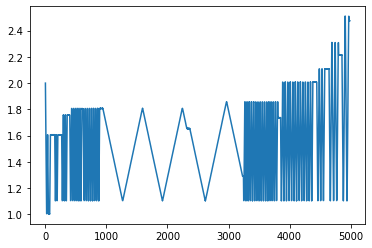

In [3]:
plt.plot(signal[::10000])
#plt.xlim((4000,4400))

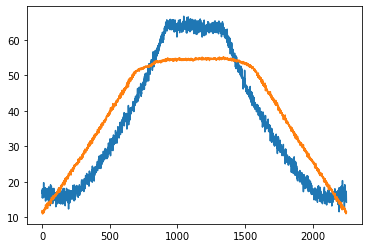

In [54]:
plt.plot(force[pulls[2][0]:pulls[2][1]:100])
plt.plot(distance[pulls[2][0]:pulls[2][1]:100] * 100)

[1.00177161 1.01685989 1.03194817 1.04703644 1.06212472 1.077213
 1.09230128 1.10738956 1.12247783 1.13756611 1.15265439 1.16774267
 1.18283095 1.19791923 1.2130075  1.22809578 1.24318406 1.25827234
 1.27336062 1.28844889 1.30353717 1.31862545 1.33371373 1.34880201
 1.36389028 1.37897856 1.39406684 1.40915512 1.4242434  1.43933167
 1.45441995 1.46950823 1.48459651 1.49968479 1.51477307 1.52986134
 1.54494962 1.5600379  1.57512618 1.59021446 1.60530273 1.62039101
 1.63547929 1.65056757 1.66565585 1.68074412 1.6958324  1.71092068
 1.72600896 1.74109724 1.75618552 1.77127379 1.78636207 1.80145035
 1.81653863 1.83162691 1.84671518 1.86180346 1.87689174 1.89198002
 1.9070683  1.92215657 1.93724485 1.95233313 1.96742141 1.98250969
 1.99759797 2.01268624 2.02777452 2.0428628  2.05795108 2.07303936
 2.08812763 2.10321591 2.11830419 2.13339247 2.14848075 2.16356902
 2.1786573  2.19374558 2.20883386 2.22392214 2.23901041 2.25409869
 2.26918697 2.28427525 2.29936353 2.31445181 2.32954008 2.344628

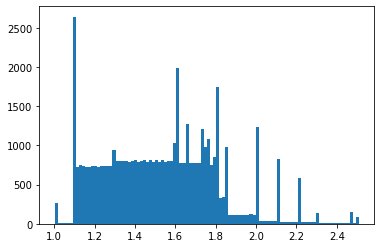

In [6]:
%matplotlib inline
from util import find_pulls
pulls = find_pulls(signal)
print(len(pulls))
print(max(signal))

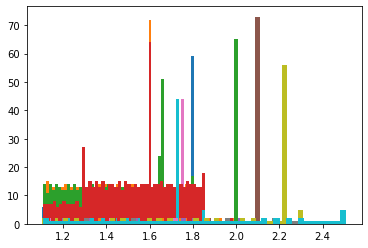

In [42]:
dict_pulls = []
for index, pull in enumerate(pulls):
    region = signal[pull[0]:pull[1]][::10000]
    bars = plt.hist(region, bins=50)
    first_top = last_top = 0
    time = 0
    if index:
        time = int((pull[0] - pulls[index - 1][1]) / frequency * 1000)
    for index, sig in enumerate(region):
        if not first_top and sig > bars[1][-2]:
            first_top = pull[0] + index * 10000
        if first_top and not last_top and sig < bars[1][-2]:
            last_top = pull[0] + index * 10000
    dict_pulls.append({'start': pull[0],
                      'stop': pull[1],
                       'len': pull[1] - pull[0],
                      'pull_stop': first_top,
                      'relax_start': last_top,
                      'rest': time})

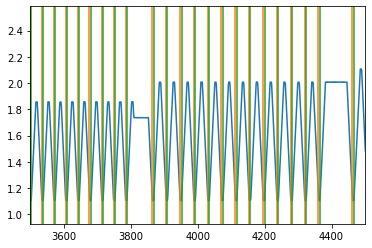

In [21]:
plt.plot(signal[::10000])
for (start, stop) in pulls:
    plt.axvline(start // 10000, c='tab:green')
    plt.axvline(stop // 10000, c='tab:orange')
    plt.xlim((3500,4500))

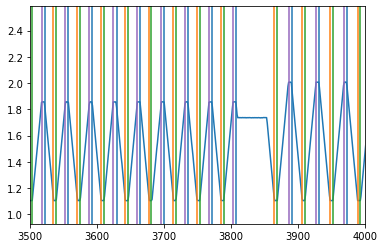

In [40]:
plt.plot(signal[::10000])
for pull in dict_pulls:
    plt.axvline(pull['start'] // 10000, c='tab:green')
    plt.axvline(pull['stop'] // 10000, c='tab:orange')
    plt.axvline(pull['pull_stop'] // 10000, c='tab:purple')
    plt.axvline(pull['relax_start'] // 10000, c='tab:blue')
    
    plt.xlim((3500,4000))

In [43]:
from scipy.stats import hmean
target = 5000
pullens = [pull[1] - pull[0] for pull in pulls]
pull_points = int(hmean(pullens))
# pull_points = pulls[0][1] - pulls[0][0]
kernel_size = pull_points // 5000
kernel = np.ones(kernel_size) / kernel_size
smooth_force = np.convolve(force, kernel, mode='same')

In [44]:
print(pulls[0])
print(len(curves), len(pulls))

(242000, 467000)


NameError: name 'curves' is not defined

In [45]:
curves = {}
for index, pull in enumerate(dict_pulls):
    identifier = 'curve_' + str(index + 1)
    if pull['len'] > 2 * target * kernel_size or pull['len'] < target * kernel_size / 2:
        continue
    curves[identifier] = {'pull_force': smooth_force[pull['start']:pull['pull_stop']][::kernel_size],
                         'dist': distance[pull[0]:pull[1]][::kernel_size],
                         'sign': signal[pull[0]:pull[1]][::kernel_size],
                         'rest': pull['rest']}
print(curves.keys())

KeyError: 0

In [ ]:
from util import write_csv

write_csv('/home/kris/proj/.data/tweez/yhsp2.csv', curves)

In [ ]:
for index, curve in enumerate(curves.values()):
    if index < 0:
        continue
    elif index > 5:
        break
    fix,ax1=plt.subplots()
    ax1.plot(curve['force'], c='tab:blue', alpha=0.8)
    ax2 = ax1.twinx()
    ax2.plot(curve['dist'], c='tab:orange', alpha=0.8)
    ax3 = ax1.twinx()
    ax3.plot(curve['sign'], c='tab:green')

In [ ]:
plt.plot(smooth_force)

In [ ]:
print(bars[0], bars[1])

In [ ]:
import h5py
for curve in curves

In [ ]:
import csv
with open('/home/kris/proj/.data/tweez/split_curves.csv', 'w') as f:
    wr = csv.writer(f)
    for curve_id, curve in curves.items():
        wr.writerow([curve_id, *[dist for dist in curve['dist']]])
        wr.writerow([curve_id, *[force for force in curve['force']]])

In [ ]:
for curve in curves.values():
    plt.figure()
    bins = plt.hist(curve['force'], bins=50)
    plt.axhline(np.mean(bins[0]), c='tab:orange')
    plt.axhline(np.mean(bins[0]) + np.std(bins[0]), c='tab:orange', alpha=0.5)
    print(np.mean(bins[0]), np.std(bins[0]))
    #plt.figure()
    #plt.plot(np.diff(curve['force']))

In [ ]:
plt.plot(curves['curve_60_573ms']['force'])
print(min(curves['curve_60_573ms']['force']))


In [ ]:
def simple_slope(f, index, size):
    return (f[min(len(f) - 1, index + size)] - f[max(0, index - size)]) / (2 * size)

In [ ]:
for curve in curves.values():
    slopes = []
    for index, force in enumerate(curve['force']):
        slopes.append(simple_slope(curve['force'], index, 50))
    plt.plot(slopes)
    #plt.plot(curve['force'])
plt.axhline(0)

In [ ]:
single = curves['curve_1_0ms']
slopes = []
for index, force in enumerate(single['force']):
    slopes.append(simple_slope(single['force'], index, 50))
plt.plot(slopes)

subzeros = []
for index, slope in enumerate(slopes[1000:-1000]):
    if slope < 0:
        subzeros.append(index)
for index, sub in enumerate(reversed(subzeros)):
    if subzeros[-1] == subzeros[-2] + 1:
        subzeros.pop(-1)
    else:
        break
    #print(sub, index)
print(len(subzeros))
plt.axvline(subzeros[0] + 1000)
plt.axvline(subzeros[-1] + 1000)
plt.figure()
plt.plot(single['force'])
plt.axvline(subzeros[0] + 1000)
plt.axvline(subzeros[-1] + 1000)
